# Lab 6: Convolutional Neural Networks
Lab 6 will follow a lot of the same steps that lab 5 did, but instead of using a feedforward neural network (FNN) you'll be using a convolutional neural network (CNN). CNNs work well when the inputs have spatial patterns that can be learned. Images fall into this category as pixels nieghboring pixels are often correlated. CNNs follow have a basic form of INPUT -> CONV_LAYER(CONV -> ACTIVATION_FUNCTION -> POOL)*d -> FNN where CONV_LAYER can have d layers and the FNN at the end can be as deep or shallow as you want. 

For the rest of this explanation I'm about to drop some knowledge straight out of [Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1). All images are from this site, unless otherwise noted.

## Convolutions
The main workhorse of the CNN is the kernel. The kernel is a learnable matrix, which is used to pick out (indicated by a strong activation) visual features. Below is an example of a 3x3 kernel (dark blue) convolving over the width and height an image to produce an output (grey).
![2dConvSingleKernel](img/2dConvKernel.gif)

The kernel is essentially a weighted sum over the inputs. A more concrete example is below.
![2dConvWithNums](img/2dConvWithNums.gif)


## Striding
Sometimes when we're performing convolutions we want the output to be smaller than the input. This can be achieved by increasing the size of our kernels (not the best way to achieve arbitrary shrinkage) or making the kernel skip over some pixels when convolving across an image.

![2dConvWithStriding](img/2dConvWithStriding.gif)

The image above has a stride of two, which reduces the output shape by a factor of 2. A stride of 3 would reduce the output shape by a factor of 3, and so on.

Another way to reduce size is with a pooling operation

## Pooling

Pooling is a technique to introduce invariance to small translations as well as reduce the output size. There are many forms of pooling using averaging, L2-norms, but max pooling is the most common. An example of max pooling with a stride of 2 over the output of each convolution of a 2x2 kernel is below

![maxpool](img/maxpool.jpeg)
[source](http://cs231n.github.io/convolutional-networks/)


## Padding
Now you know two ways of reducing the size of each layer using kernels, and striding. But if you keep reducing size eventually you'll have nothing to work with and you can't make arbitrarily deep models. Padding is a technique where you concatenate pixels to the edges of an image, so that the output after a convlutional layer is that same size as the input. This can also be done during a pooling step, but that's not super common.
![2dConvWithPadding](img/2dConvWithPadding.gif)

## Output Channels
Why limit yourself to only one kernel of a specific size? PyTorch allows you to create multiple multiple output channels for each kernel of the same size you use. In this case, your output is no longer a 2d matrix, but a matrix with width, height, and depth depending on the number of channels uses. Below is an example of a single kernel convolving over a single 2 dimensional space, with output 5 channels. 

![outputChannelDepth](img/outputChannelDepth.jpeg)
[source](http://cs231n.github.io/convolutional-networks/)

## Input Channels
![colorChannels](img/colorChannels.jpeg)
In this assignemnt we're still dealing with black and white images which have only one channel (grey). Basically this part isn't relevant to this lab, but hey, why not stick around since you're already here. Dealing with color images means you have three input channels. So how do you perform 2d convolutions over this kind of input? Let's assume we're only dealing with a single output channel, in this case there will be one unique (trainable) kernel for each channel. This collection of kernels is known as a filter. Each kernel then convolves over each input channel.
![multiInputChannel](img/multiInputChannel.gif)

The filter then produces multiple outputs (one for each kernel), which are summed together to produce a single output for this filter, or collection of kernels. There's also a bias term, which is the same value added to each kernel.
![filterSumming](img/filterSumming.gif)

Hey, look at you. You made it all the way here. And even after I told you that it wasn't necessary for the lab. Take a moment to feel good about yourself. Remember to take some time everyday to reflect on what you've done well, even if it's making your bed, brushing your teeth, or taking time to read a book. Give yourself some credit, you deserve it.

First thing's first. Install the module `torchsummary` with `pip install torchsummary`

In [30]:
%matplotlib inline 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import inspect
from torchsummary import summary

## Gathering data
Since you already learned how to pull data from PyTorch I'll do that for you. However, do notice how I'm using the transform argument. I'm performing this on the testing dataset to make things a little harder, but you could also do this on the training dataset to augment your data with randomly rotated images.

In [2]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                            train=False, 
                            transform=transforms.ToTensor(),
                            download = True)
# train_dataset = dsets.MNIST(root='./data', 
#                             train=True, 
#                             transform=transforms.Compose([
#                                 transforms.RandomRotation(degrees = 10),
#                                 transforms.ToTensor(),
#                                 ]),
#                             download=True)

test_dataset = dsets.MNIST(root='./data', 
                            train=False, 
                            transform=transforms.Compose([
                                transforms.RandomRotation(degrees = 25),
                                transforms.ToTensor(),
                                ]),
                            download = True)

In [3]:
print(train_dataset.train_data.size())
print(train_dataset.train_labels.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


In [4]:
print(test_dataset.test_data.size())
print(test_dataset.test_labels.size())

torch.Size([10000, 28, 28])
torch.Size([10000])


In [5]:
batch_size = 100
n_iters = 3000
num_epochs = 5

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

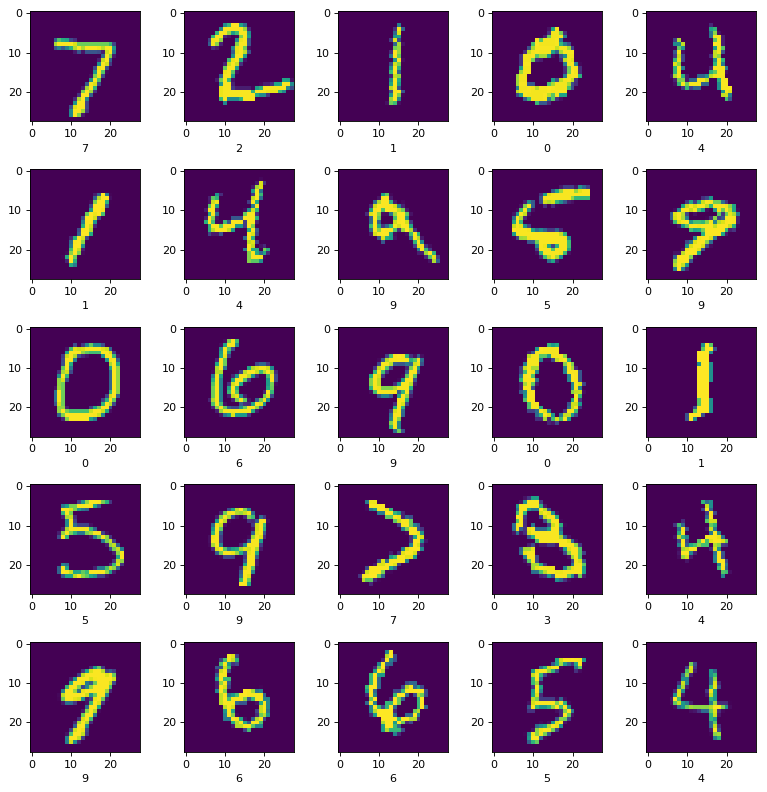

In [6]:
import matplotlib.pyplot as plt
#### your code here ###

x = next(iter(test_loader))

plotData = x[0][0:25]
labelData = x[1][0:25]

fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for i in range(25):
    plt.subplot(5,5,i + 1, xmargin = 2.0)
    plt.xlabel(str(labelData[i].numpy()))
    plt.imshow(plotData[i][0].numpy())
    plt.tight_layout()
plt.show()

## Building a Vanilla CNN
Below, fill in the code fill in the code to build a model following this struction.
INPUT -> 
CONV(outputChannels = 16, kernelSize = 5, stride=1, padding = 0) -> ReLU -> MAXPOOL(kernelSize=2) ->
CONV(outputChannels = 32, kernelSize = 5, stride=1, padding = 0) -> ReLU MAXPOOL(kernelSize=2) ->
FCNN(32 * 4 * 4, 10)

In the forward pass you might have to reshape your outputs to fit into a 2 dimensional FCNN.

In [7]:
class CNNModelStatic(nn.Module):
    def __init__(self):
        super(CNNModelStatic, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2 
        out = self.maxpool2(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)

        return out

### Model Summary
Using the summary function from torchsummary print out the layers, shapes, and number of parameters in the model.

In [8]:
model = CNNModelStatic()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
              ReLU-2           [-1, 16, 24, 24]               0
         MaxPool2d-3           [-1, 16, 12, 12]               0
            Conv2d-4             [-1, 32, 8, 8]          12,832
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Linear-7                   [-1, 10]           5,130
Total params: 18,378
Trainable params: 18,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.07
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [9]:

class CNNModelDynamic(nn.Module):
    def __init__(self, input_shape = 28, n_classes = 10,
                 in_channels_list = [1, 16], out_channels_list = [16, 32],
                 kernel_size_list = [5, 5], stride_list = [1, 1],
                 padding_list = [0,0], pool_kernel_list = [2, 2],
                 pool_stride_list = [2, 2],
                 pooling_list = [nn.MaxPool2d, nn.MaxPool2d], activations_list = [nn.ReLU(), nn.ReLU()]):
        super(CNNModelDynamic, self).__init__()
        localArgs = locals().items()
        argLens = set()
        ignoredArgs = ['self', "__class__", "input_shape", "n_classes"]
        for argName, arg in localArgs:
            if argName not in ignoredArgs:
                argLens.add(len(arg))
        assert len(argLens) == 1, ("mismatch in lengths of arguments."
                                   "All params for each layer must be specified")
#         listLengths = np.array([len()])
        # Convolution 1
        finalOutputSize = self.calculateFinalOutputSize(input_shape,kernel_size_list, stride_list,
                                         padding_list, pool_kernel_list, pool_stride_list)
        modules = list()
        for layerIdx in range(0, argLens.pop()):
            modules.append(nn.Conv2d(in_channels = in_channels_list[layerIdx],
                                 out_channels = out_channels_list[layerIdx],
                                 kernel_size = kernel_size_list[layerIdx],
                                 stride = stride_list[layerIdx],
                                 padding = padding_list[layerIdx]))
            modules.append(activations_list[layerIdx])
            modules.append(pooling_list[layerIdx](kernel_size = pool_kernel_list[layerIdx],
                                                  stride = pool_stride_list[layerIdx]))
        self.convolutions = nn.Sequential(*modules)
        print(finalOutputSize*out_channels_list[-1])
        print(finalOutputSize)
        print(out_channels_list[-1])
        self.finalLayer = nn.Linear(finalOutputSize**2*out_channels_list[-1], n_classes)
        
        
    def calculateFinalOutputSize(self, input_shape, kernel_size_list, stride_list,
                                 padding_list, pool_kernel_list, pool_stride_list):
        finalOutputShape = input_shape
        for index in range(0, len(kernel_size_list)):
            # convolution layer
            k = kernel_size_list[index]
            p = padding_list[index]
            s = stride_list[index]
            finalOutputShape = (finalOutputShape - k + 2*p)/s + 1
            # pooling layer
            k = pool_kernel_list[index]
            s = pool_stride_list[index]
            finalOutputShape = (finalOutputShape - k)/s + 1
        return(int(finalOutputShape))
        
        
    def forward(self, x):
        out = self.convolutions(x)
        out = out.view(out.size(0), -1)
        out = self.finalLayer(out)
        return(out)

In [25]:
model = CNNModelDynamic()
summary(model, (1, 28, 28))

128
4
32
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
              ReLU-2           [-1, 16, 24, 24]               0
         MaxPool2d-3           [-1, 16, 12, 12]               0
            Conv2d-4             [-1, 32, 8, 8]          12,832
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Linear-7                   [-1, 10]           5,130
Total params: 18,378
Trainable params: 18,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.07
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [28]:
myIter = 0
bestAcc = 0
patience = 5
checksWithoutIncrease = 0
for epoch in range(num_epochs):
    print("Epoch: {}".format(epoch))
    for i, (images, labels) in enumerate(train_loader):
        if checksWithoutIncrease == patience:
            break
        # Load images
        images = images.requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        myIter += 1
        if myIter % 50 == 0:
#             print("iter: {}".format(myIter))
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images
                images = images.requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            if accuracy > bestAcc:
                bestAcc = accuracy
                checksWithoutIncrease = 0
            else:
                checksWithoutIncrease += 1
            print('\tIteration: {}. Loss: {}. Testing Accuracy: {}'.format(myIter, loss.item(), accuracy))
    if checksWithoutIncrease == patience:
        print("Best model found with an accuracy of {}".format(bestAcc))
        break

Epoch: 0
	Iteration: 50. Loss: 0.19503825902938843. Testing Accuracy: 88
	Iteration: 100. Loss: 0.13602182269096375. Testing Accuracy: 92
	Iteration: 150. Loss: 0.08616552501916885. Testing Accuracy: 93
	Iteration: 200. Loss: 0.12209981679916382. Testing Accuracy: 92
	Iteration: 250. Loss: 0.07716279476881027. Testing Accuracy: 94
	Iteration: 300. Loss: 0.10406559705734253. Testing Accuracy: 95
	Iteration: 350. Loss: 0.1754298359155655. Testing Accuracy: 94
	Iteration: 400. Loss: 0.013903510756790638. Testing Accuracy: 95
	Iteration: 450. Loss: 0.08044929802417755. Testing Accuracy: 94
	Iteration: 500. Loss: 0.1164034828543663. Testing Accuracy: 94
	Iteration: 550. Loss: 0.011505043134093285. Testing Accuracy: 95
Best model found with an accuracy of 95
